# Why Pretraining?
*Compare Base Model with Continued Pre-train Model*  


In [ ]:
import torch

def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()

## Load Base Model

In [ ]:
# Load model
from transformers import AutoModelForCausalLM, AutoTokenizer

base_model_name_or_path = "Qwen/Qwen2-0.5B"
# load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name_or_path,
    device_map="auto", # change to auto if you have access to a GPU
    torch_dtype=torch.float16
)

base_tokenizer = AutoTokenizer.from_pretrained(base_model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Generate text
prompt = "Bạc xỉu hay Bạc sỉu là một món đồ uống"
inputs = base_tokenizer(prompt, return_tensors="pt").to('cuda')

outputs = base_model.generate(
    **inputs,
    use_cache=True,
    max_new_tokens=128,
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.1
)

print(base_tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Bạc xỉu hay Bạc sỉu là một món đồ uống có nguồn gốc từ Trung Quốc. Nó được sử dụng trong các bữa tiệc, lễ hội và các hoạt động văn hóa khác. Nó thường được dùng để thay thế cho rượu bia khi không có sẵn hoặc cần thiết.
Bạc xỉu có nhiều loại khác nhau, tùy thuộc vào nguồn gốc của nó. Một số loại có thể được chế biến bằng các nguyên liệu như cà phê, trà, sữa, nước ngọt, dầu ăn, hạt, trái cây, rau, thịt, cá, trứng, sữa, và thậm chí là thực phẩm tự nhiên. Một số loại còn có thể được chế biến


# Data Preparation

## tokenize dataset

In [ ]:
!pip install -Uq datasets

In [ ]:
import datasets
# dataset cần chứa cột `text`
dataset = datasets.load_dataset('iamnguyen/food_content', split='train')
dataset

Dataset({
    features: ['text'],
    num_rows: 1113
})

In [ ]:
from transformers import AutoTokenizer
# load model and tokenizer
base_model_name_or_path = "Qwen/Qwen2-0.5B"
tokenizer = AutoTokenizer.from_pretrained(base_model_name_or_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tokenization(example):
    # Tokenize
    tokens = tokenizer.tokenize(example["text"])

    # Convert tokens to ids
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Add <bos>, <eos> tokens to the front and back of tokens_ids
    # bos: begin of sequence, eos: end of sequence
    token_ids = [tokenizer.eos_token_id] + token_ids + [tokenizer.eos_token_id]
    example["input_ids"] = token_ids

    # We will be using this column to count the total number of tokens
    # in the final dataset
    example["num_tokens"] = len(token_ids)
    return example

dataset = dataset.map(tokenization, num_proc=2, load_from_cache_file=False)
dataset

Map (num_proc=2):   0%|          | 0/1113 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'num_tokens'],
    num_rows: 1113
})

In [ ]:
sample = dataset[3]

print("text", sample["text"][:30]) #
print("\ninput_ids", sample["input_ids"][:30])
print("\nnum_tokens", sample["num_tokens"])

text Almojábana là một loại bánh mì

input_ids [151643, 2101, 6355, 73, 58560, 3362, 37915, 128249, 128433, 132710, 296, 23531, 128266, 94576, 1319, 78, 135614, 6871, 1630, 2584, 47742, 293, 94313, 7777, 9574, 382, 2101, 6355, 73, 58560]

num_tokens 244


## Packing data
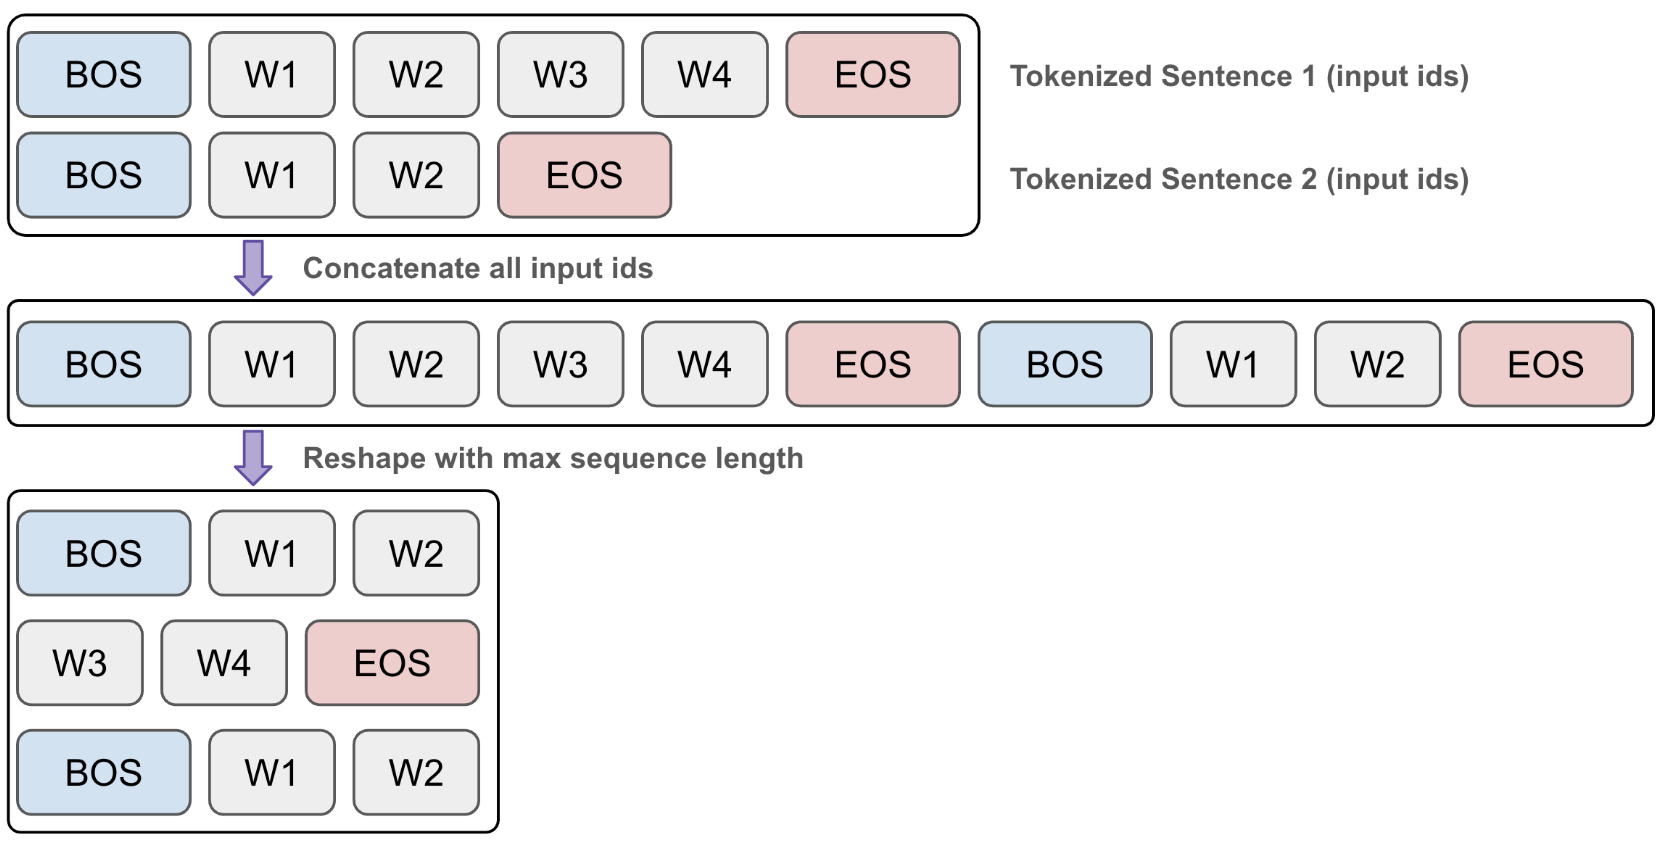

In [ ]:
import numpy as np
# số lượng token
np.sum(dataset["num_tokens"])

756144

In [ ]:
# nối các token lại
input_ids = np.concatenate(dataset["input_ids"])
print(len(input_ids))

756144


In [ ]:
max_seq_length = 1024
total_length = len(input_ids) - len(input_ids) % max_seq_length
print(total_length)

755712


In [ ]:
input_ids = input_ids[:total_length]
print(input_ids.shape)

(755712,)


In [ ]:
# pack các token lại thành các sequence, mỗi sequence 1024 token
input_ids_reshaped = input_ids.reshape(-1, max_seq_length).astype(np.int32)
input_ids_reshaped.shape

(738, 1024)

In [ ]:
type(input_ids_reshaped)

numpy.ndarray

In [ ]:
input_ids_list = input_ids_reshaped.tolist()
packaged_pretrain_dataset = datasets.Dataset.from_dict(
    {"input_ids": input_ids_list}
)
print(packaged_pretrain_dataset)

Dataset({
    features: ['input_ids'],
    num_rows: 738
})


In [ ]:
# lưu thành file parquet
file_path = '/content/datasets/data_food.parquet'
packaged_pretrain_dataset.to_parquet(file_path)

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3025800

# Model Training

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
# load model and tokenizer
model_name_or_path = "Qwen/Qwen2-0.5B"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cuda",
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import datasets
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset_name, split="train"):
        """Initializes the custom dataset object."""
        self.dataset = datasets.load_dataset(
            "parquet",
            data_files=dataset_name,
            split=split
        )

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves a single data sample from the dataset
        at the specified index
        """
        # Convert the lists to a LongTensor for PyTorch
        input_ids = torch.LongTensor(self.dataset[idx]["input_ids"])
        labels = torch.LongTensor(self.dataset[idx]["input_ids"])

        # Return the sample as a dictionary
        return {"input_ids": input_ids, "labels": labels}

In [ ]:
# create dataset
train_dataset = CustomDataset(dataset_name='/kaggle/working/data_food.parquet')

In [ ]:
!git config --global credential.helper store
!huggingface-cli login --add-to-git-credential --token hf_...

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='output',

    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=10,
    optim='adamw_torch',
    gradient_checkpointing=True,

    logging_strategy='steps',
    logging_steps=8,
    eval_strategy='no',
    save_strategy='steps',
    save_steps=16,
    save_total_limit=1,
    report_to='none',
    push_to_hub=True,
    hub_model_id='nlplabtdtu/Qwen-food',
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=None,
)

In [ ]:
trainer.train()
# trainer.train(resume_from_checkpoint='last-checkpoint')

In [ ]:
# push model and tokenizer to hub
model.push_to_hub('nlplabtdtu/Qwen-food')
tokenizer.push_to_hub('nlplabtdtu/Qwen-food')

# Test Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model1 = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-1.5B",
    device_map="auto",
)
tokenizer1 = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B")

In [ ]:
prompt = "Thịt cua là phần thịt được lấy từ phần thân và phần càng"

inputs = tokenizer1(prompt, return_tensors="pt").to(model1.device)

outputs = model1.generate(
    **inputs,
    use_cache=True,
    max_new_tokens=128,
    do_sample=True,
    temperature=1.0,
)

print(tokenizer1.decode(outputs[0], skip_special_tokens=True))

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name_or_path = "nlplabtdtu/Qwen-food"
model2 = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [ ]:
prompt = "Thịt cua là phần thịt được lấy từ phần thân và phần càng"

inputs = tokenizer(prompt, return_tensors="pt").to(model2.device)

outputs = model2.generate(
    **inputs,
    use_cache=True,
    max_new_tokens=128,
    do_sample=True,
    temperature=1.0,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))